In [33]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import EnergyScore
from models import FNO_reparam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Subsampling rate
sampling_rate = 2
ntrain = 1500
ntest = 150
batch_size = 32

t_train= np.arange(5,10)
t_train_len = len(t_train)
t_eval = np.arange(10,15)
t_eval_len = len(t_eval)
data = np.load("data/ks_1d_data.npy").astype(np.float32)

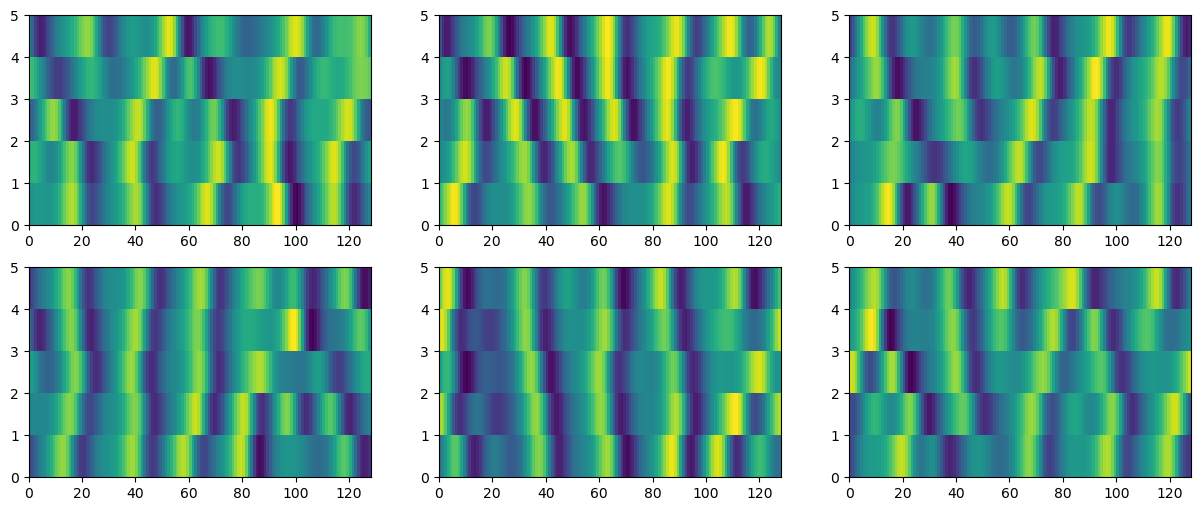

In [35]:
# Example plot
n_samples = np.random.randint(0,ntrain,3)

fig, axs = plt.subplots(2, 3, figsize = (15,6))
for i, sample in enumerate(n_samples):
    axs[1,i].pcolormesh(data[sample, t_train])
    axs[0,i].pcolormesh(data[sample, t_eval])

In [36]:
grid_range = 1

x_data = torch.tensor(data[:,t_train])
y_data = torch.tensor(data[:,t_eval])
x_data = (x_data - x_data.mean(dim = (0,2), keepdim=True)) / x_data.std(dim = (0,2), keepdim=True)
y_data = (y_data - y_data.mean(dim = (0,2), keepdim=True)) / y_data.std(dim = (0,2), keepdim=True)
size_x = x_data.shape[2]
size_x_train = int(size_x/sampling_rate)

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain,:,:,::sampling_rate], y_data[:ntrain,:,:,::sampling_rate]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
gridx_train = torch.tensor(np.linspace(0, grid_range, size_x_train), dtype=torch.float)
gridx_train = gridx_train.reshape(1, 1, 1, size_x_train)
gridx_test = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
gridx_test = gridx_test.reshape(1, 1, 1, size_x)


x_train = torch.cat((x_train, gridx_train.repeat([ntrain, 1, t_train_len,1])), dim=1)
x_test = torch.cat((x_test, gridx_test.repeat([ntest, 1, t_train_len,1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [37]:
l2loss = LpLoss(d=2, p=2, L = [10.0,50.0])
energy_score = EnergyScore(d = 2, p = 2, type = "lp", L = [10.0,50.0])

# Training parameters
epochs = 25
learning_rate = 0.0005
dropout_rate = 0.2

# MC dropout

In [38]:
def generate_mc_samples(model, x, shape, n_samples=100):
    samples = torch.zeros(*shape, n_samples)
    for i in range(n_samples):
        with torch.no_grad():
            samples[...,i] = model(x).detach()
    return samples

In [39]:
model = FNO(n_modes=(8,16), hidden_channels=64, projection_channels=32,
             in_channels = 2, use_mlp=True, mlp_dropout=dropout_rate)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 2412289 parameters.


In [40]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [41]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-1.0782, Train-MSE-0.9892, Train-L2-0.0312, Test-L2-0.0323
Epoch-1, Time-1.0703, Train-MSE-0.8886, Train-L2-0.0295, Test-L2-0.0299
Epoch-2, Time-0.9953, Train-MSE-0.7639, Train-L2-0.0274, Test-L2-0.0281
Epoch-3, Time-1.0107, Train-MSE-0.6915, Train-L2-0.0261, Test-L2-0.0268
Epoch-4, Time-1.0494, Train-MSE-0.6451, Train-L2-0.0252, Test-L2-0.0262
Epoch-5, Time-1.0480, Train-MSE-0.6092, Train-L2-0.0245, Test-L2-0.0253
Epoch-6, Time-1.0936, Train-MSE-0.5743, Train-L2-0.0237, Test-L2-0.0250
Epoch-7, Time-0.9814, Train-MSE-0.5517, Train-L2-0.0233, Test-L2-0.0246
Epoch-8, Time-1.0470, Train-MSE-0.5244, Train-L2-0.0227, Test-L2-0.0239
Epoch-9, Time-1.0249, Train-MSE-0.5039, Train-L2-0.0222, Test-L2-0.0237
Epoch-10, Time-1.0033, Train-MSE-0.4864, Train-L2-0.0219, Test-L2-0.0235
Epoch-11, Time-0.9994, Train-MSE-0.4798, Train-L2-0.0217, Test-L2-0.0230
Epoch-12, Time-1.0376, Train-MSE-0.4604, Train-L2-0.0213, Test-L2-0.0231
Epoch-13, Time-1.0536, Train-MSE-0.4471, Train-L2-0.0210, Tes

In [42]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = generate_mc_samples(model, x, y.shape, n_samples=500)
        pred.append( out )


pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, t_eval_len, size_x), y_test.view(-1, t_eval_len, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.44168514013290405
ES: 12.49783992767334


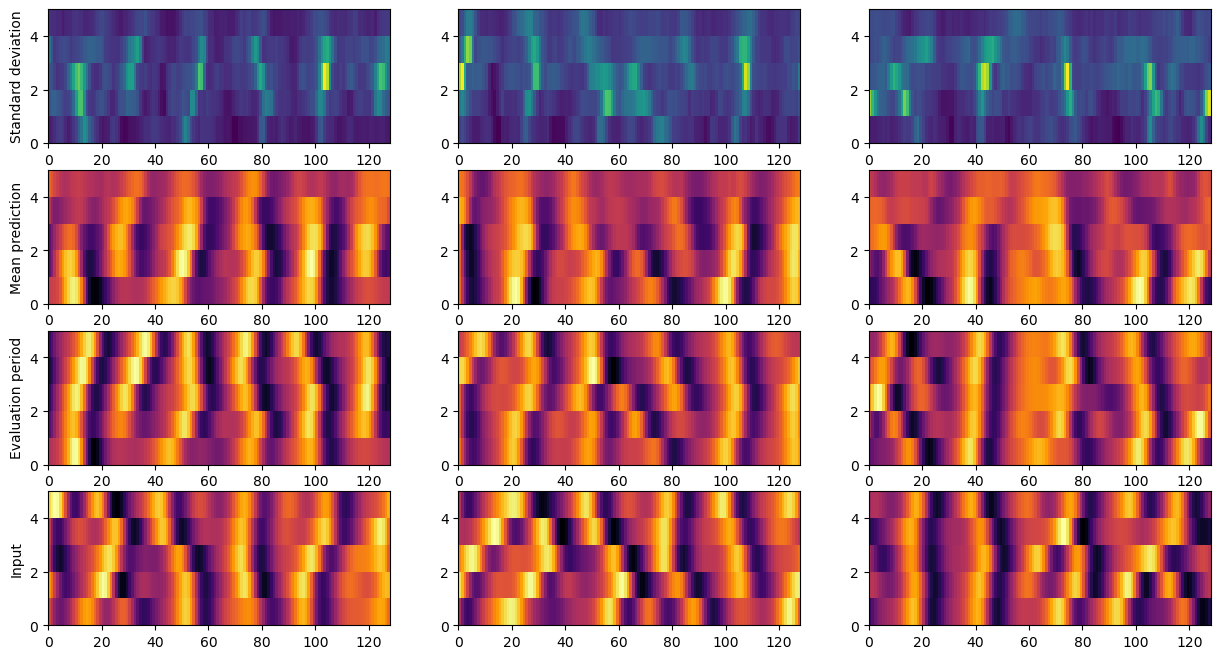

In [43]:
# Example plot
n_samples = np.random.randint(0,ntest,3)

fig, axs = plt.subplots(4, 3, figsize = (15,8))
for i, sample in enumerate(n_samples):
    axs[3,i].pcolormesh(x_test[sample,0], cmap = "inferno")
    axs[2,i].pcolormesh(y_test[sample,0], cmap = "inferno")
    axs[1,i].pcolormesh(pred[sample,0].mean(axis = -1), cmap = "inferno")
    axs[0,i].pcolormesh(pred[sample,0].std(axis = -1))

labels = ["Input", "Evaluation period", "Mean prediction", "Standard deviation"]

for i in range(4):
    axs[i,0].set_ylabel(labels[3-i])

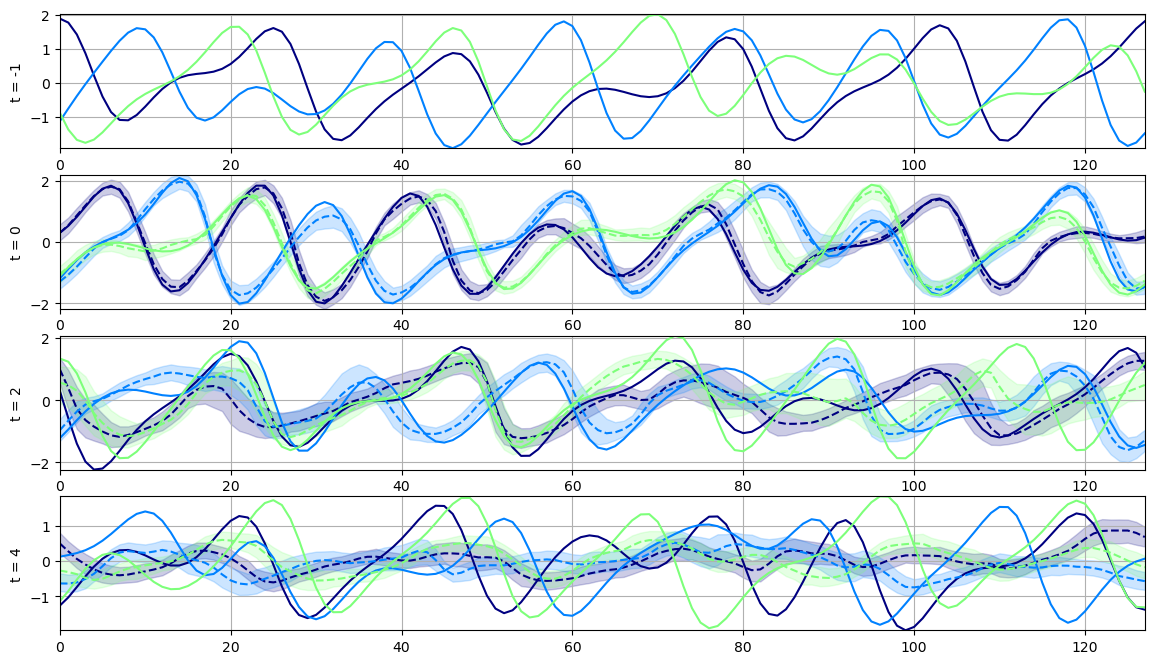

In [44]:
# Example plot
n_samples = np.random.randint(0,ntest,3)

colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(4, 1, figsize = (14, 8))
for i, sample in enumerate(n_samples):
    axs[0].plot(x_test[i,0, 4], color=colors[i], label='Actual')
    axs[0].set_ylabel("t = -1")
    t = 0
    axs[1].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[1].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[1].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[1].set_ylabel(f"t = {t}")
    t = 2
    axs[2].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[2].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[2].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[2].set_ylabel(f"t = {t}")
    t = 4
    axs[3].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[3].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[3].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[3].set_ylabel(f"t = {t}")

for i in range(4):
    axs[i].grid(True)
    axs[i].margins(0)

# PFNO

In [55]:
sample_model = FNO_reparam(n_modes=(8,16), hidden_channels=64, projection_channels=32, in_channels=2, n_samples = 25,
                           use_mlp=True, mlp_dropout=0.05)
sample_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [56]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-1.3326, Train-L2-0.4962, Test-L2-0.5136
Epoch-1, Time-1.2950, Train-L2-0.4647, Test-L2-0.4696
Epoch-2, Time-1.3102, Train-L2-0.4255, Test-L2-0.4385
Epoch-3, Time-1.3081, Train-L2-0.4035, Test-L2-0.4203
Epoch-4, Time-1.3896, Train-L2-0.3886, Test-L2-0.4086
Epoch-5, Time-1.3132, Train-L2-0.3752, Test-L2-0.4012
Epoch-6, Time-1.2535, Train-L2-0.3652, Test-L2-0.3912
Epoch-7, Time-1.2887, Train-L2-0.3550, Test-L2-0.3854
Epoch-8, Time-1.2825, Train-L2-0.3454, Test-L2-0.3776
Epoch-9, Time-1.3360, Train-L2-0.3397, Test-L2-0.3721
Epoch-10, Time-1.3315, Train-L2-0.3317, Test-L2-0.3737
Epoch-11, Time-1.3207, Train-L2-0.3273, Test-L2-0.3701
Epoch-12, Time-1.4346, Train-L2-0.3198, Test-L2-0.3654
Epoch-13, Time-1.2985, Train-L2-0.3151, Test-L2-0.3666
Epoch-14, Time-1.3217, Train-L2-0.3096, Test-L2-0.3615
Epoch-15, Time-1.4011, Train-L2-0.3052, Test-L2-0.3612
Epoch-16, Time-1.2796, Train-L2-0.3010, Test-L2-0.3605
Epoch-17, Time-1.3325, Train-L2-0.2974, Test-L2-0.3607
Epoch-18, Time-1.386

In [57]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = sample_model(x, n_samples = 500).detach().cpu()
        pred.append( out )


pred = torch.cat((pred))
mse = F.mse_loss(pred.mean(axis = -1).view(-1, t_train_len, size_x), y_test.view(-1, t_train_len, size_x)).item()
es = energy_score(pred, y_test).item()

print('MSE:', mse)
print('ES:', es)

MSE: 0.44912606477737427
ES: 10.540818214416504


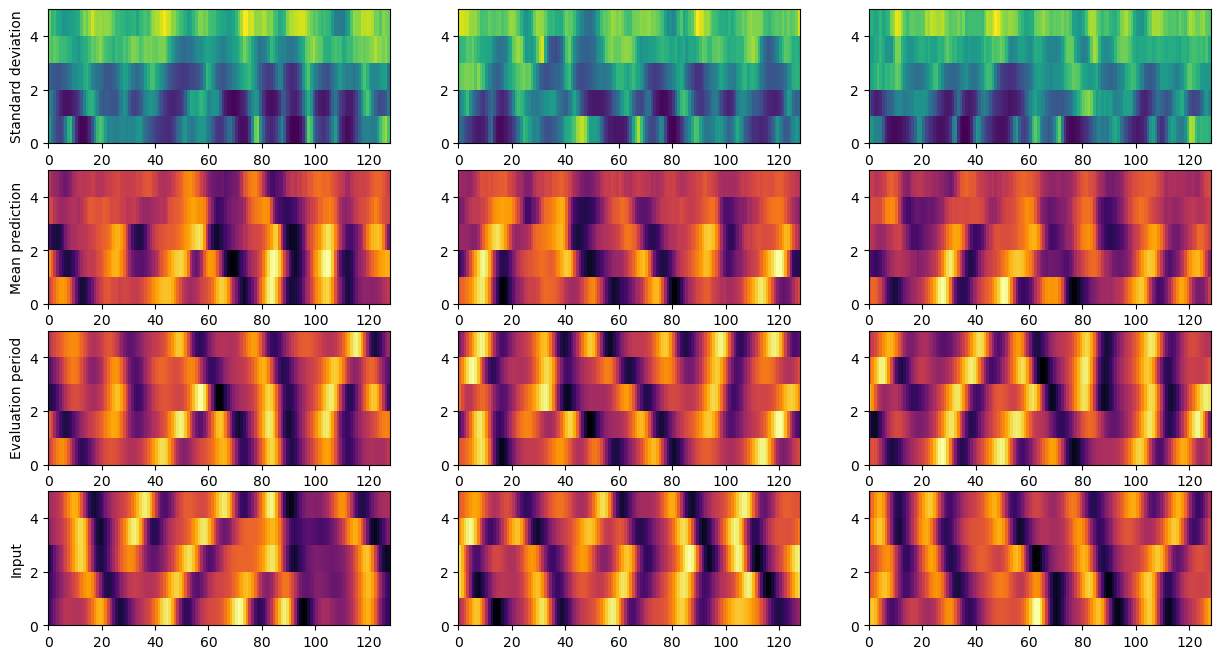

In [58]:
# Example plot
n_samples = np.random.randint(0,ntest,3)

fig, axs = plt.subplots(4, 3, figsize = (15,8))
for i, sample in enumerate(n_samples):
    axs[3,i].pcolormesh(x_test[sample,0], cmap = "inferno")
    axs[2,i].pcolormesh(y_test[sample,0], cmap = "inferno")
    axs[1,i].pcolormesh(pred[sample,0].mean(axis = -1), cmap = "inferno")
    axs[0,i].pcolormesh(pred[sample,0].std(axis = -1))

labels = ["Input", "Evaluation period", "Mean prediction", "Standard deviation"]

for i in range(4):
    axs[i,0].set_ylabel(labels[3-i])

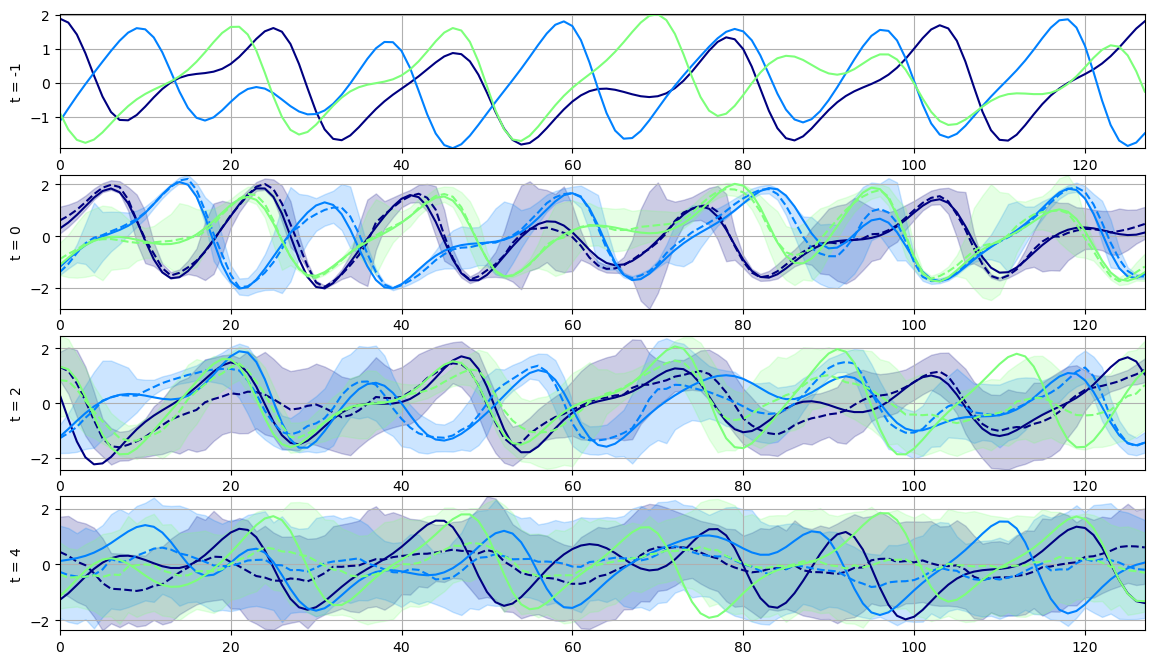

In [59]:
# Example plot
n_samples = np.random.randint(0,ntest,3)

colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(4, 1, figsize = (14, 8))
for i, sample in enumerate(n_samples):
    axs[0].plot(x_test[i,0, 4], color=colors[i], label='Actual')
    axs[0].set_ylabel("t = -1")
    t = 0
    axs[1].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[1].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[1].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[1].set_ylabel(f"t = {t}")
    t = 2
    axs[2].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[2].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[2].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[2].set_ylabel(f"t = {t}")
    t = 4
    axs[3].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[3].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[3].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[3].set_ylabel(f"t = {t}")

for i in range(4):
    axs[i].grid(True)
    axs[i].margins(0)

In [60]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

MSE-Dropout: 0.44168514013290405
ES-Dropout: 12.49783992767334
MSE: 0.44912606477737427
ES: 10.540818214416504
